Check out Kaggle at https://www.kaggle.com/c/conways-reverse-game-of-life-2020. The objective is to reverse Conway's Game of Life Board (25x25 cells) to learn its position $\delta$ steps ago ($1<=\delta<=5$). In this notebook, we adapt "Image-to-Image Translation with Conditional Adverserial Networks" (Isola et al., 2017) by training a discriminator and generator conditioned on input images.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import collections
import math
import gc
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Lambda, Flatten, Conv2DTranspose
from tensorflow.keras.layers import Dropout, GaussianNoise, Input, UpSampling2D, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
import sklearn.model_selection
from copy import deepcopy
import sklearn.metrics

<h2>Data Preprocessing</h2>

In [2]:
start = time.time()
data = pd.read_csv("./train.csv")
X1 = data[data.columns[np.vectorize(lambda s: "stop" in s)(data.columns.values)]]
X1 = X1.values.reshape(data.shape[0],25,25,1)
delta = data["delta"].values
X2 = np.zeros((data.shape[0],5))
for i in range(data.shape[0]):
    X2[i,delta[i]-1] = 1
Y = data[data.columns[np.vectorize(lambda s: "start" in s)(data.columns.values)]]
Y = Y.values.reshape(data.shape[0],25,25,1)
print("Preprocessing Exited in "+str(time.time()-start)+" seconds")
data.shape, X1.shape, X2.shape, Y.shape

Preprocessing Exited in 5.520716905593872 seconds


((50000, 1252), (50000, 25, 25, 1), (50000, 5), (50000, 25, 25, 1))

<h2> SECTION 1: Building the Discriminator and Generator

In [3]:
def build_discriminator(lr=2e-3):
    tf.keras.backend.clear_session()
    curimg, befimg = Input((25,25,1)), Input((25,25,1))
    imginp = Concatenate()([curimg, befimg])
    mask = Input((5,))
    #Increasing Filters to Capture Relationship
    conv1 = Conv2D(filters=32, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(imginp)
    max1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv1)
    conv2 = Conv2D(filters=64, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(max1)
    max2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv2)
    #BatchNormalization for Train-Time Stability
    max2 = BatchNormalization()(max2)
    #Reducing Filters to 5-Channel Layer
    conv3 = Conv2D(filters=32, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(max2)
    max3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv3)
    fconv = Conv2D(filters=5, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(max3)
    #Discriminate on Relevant Delta
    final = Dense(5, activation="sigmoid")(Flatten()(fconv))
    final = tf.math.multiply(final,mask)
    dmodel = Model(inputs=[curimg, befimg, mask], outputs=final, name="Discriminator")
    dmodel.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(lr=lr), loss_weights=[0.5])
    return dmodel

In [4]:
def build_generator(lr=2e-3):
    tf.keras.backend.clear_session()
    imginp = Input((25,25,1))
    #Custom Training Op Needed Since deltainp is a gather
    deltainp = Input((2,), dtype=tf.int32)
    #Original N-Step Convolver Design
    conv1 = Conv2D(filters=32, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(imginp)
    max1 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding="same")(conv1)
    conv2 = Conv2D(filters=64, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(max1)
    max2 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding="same")(conv2)
    conv3 = Conv2D(filters=48, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(max2)
    max3 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding="same")(conv3)
    final = Conv2D(filters=5, kernel_size=(7,7), strides=(1,1), padding="same", activation="sigmoid")(max3)
    #Select Appropriate Board
    final = tf.transpose(final, perm=[0,3,1,2])
    final = tf.gather_nd(final, deltainp)
    final = tf.reshape(final, shape=(-1,25,25,1))
    gmodel = Model(inputs=[imginp,deltainp], outputs=final, name="Generator")
    return gmodel

<h2>SECTION 2: Completing the cGAN Model

In [6]:
def build_cgan(generator, discriminator, lr=2e-3):
    tf.keras.backend.clear_session()
    discriminator.trainable = False
    imginp = Input((25,25,1))
    #Gather ND mask like in generator
    deltainp, mask = Input((2,),dtype=tf.int32), Input((5,))
    outimg = generator([imginp, deltainp])
    disc = discriminator([imginp, outimg, mask])
    cgan = Model(inputs=[imginp,deltainp,mask], outputs=disc, name="cGAN")
    cgan.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(lr=lr))
    return cgan
build_cgan(build_generator(), build_discriminator()).summary()

Model: "cGAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
Generator (Model)               (None, 25, 25, 1)    264357      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 5)]          0                                         

In [7]:
dmodel = build_discriminator()
gmodel = build_generator()
cganmodel = build_cgan(gmodel, dmodel)

<h2>SECTION 3: Training and Inference Infrastructure

In [19]:
def generate_real_samples(inp, out, mask, size):
    indices = np.random.choice(inp.shape[0], size=size, replace=False)
    return inp[indices], out[indices], mask[indices], mask[indices]
def generate_fake_samples(generator, decX, decmask):
    gatherer = np.zeros((decX.shape[0],2),dtype=np.int32)
    gatherer[:,0], gatherer[:,1]  = np.arange(decX.shape[0]), np.argmax(decmask,axis=-1)
    pred = generator.predict_on_batch([decX, gatherer])
    exp = np.zeros((decX.shape[0],5))
    return pred, exp, gatherer

In [22]:
def batch_trainer(cgan, generator, discriminator, X1, X2, Y, batch_size=256):
    #Get a sample of real images from training set and train discriminator with 1
    realX1, realY, realX2, realO = generate_real_samples(X1,Y,X2,np.int(batch_size/2))
    drealloss = discriminator.train_on_batch([realX1, realY, realX2], realO)
    #Get samples made from the generator and train discriminator with 0
    genY, genO, deltagat = generate_fake_samples(generator, realX1, realX2)
    dfakeloss = discriminator.train_on_batch([realX1, genY, realX2], genO)
    #Train the generator with adverserial loss
    gloss = cgan.train_on_batch([realX1, deltagat, realX2], realO)
    return drealloss, dfakeloss, gloss

In [29]:
numepochs, batch_size = 20, 256
start = time.time()
numbatches = round((40000/batch_size)*numepochs)
drealloss, dfakeloss, genloss = np.zeros(numbatches), np.zeros(numbatches), np.zeros(numbatches)
checkpoints = np.vectorize(round)(np.arange(0, numbatches, numbatches/10)+numbatches/10-1)
for i in range(numbatches):
    d, f, g = batch_trainer(cganmodel, gmodel, dmodel, X1[:40000],X2[:40000],Y[:40000], batch_size)
    drealloss[i], dfakeloss[i], genloss[i] = d, f, g
    if (i in checkpoints):
        print("Checkpoint at Batch No."+str(i+1)+" in "+str(time.time()-start)+" seconds")

Checkpoint at Batch No.313 in 412.5566020011902 seconds
Checkpoint at Batch No.625 in 823.4542481899261 seconds
Checkpoint at Batch No.937 in 1246.6641552448273 seconds
Checkpoint at Batch No.1250 in 1671.261595249176 seconds
Checkpoint at Batch No.1563 in 2096.264731168747 seconds
Checkpoint at Batch No.1875 in 2520.8907351493835 seconds
Checkpoint at Batch No.2187 in 2945.4101951122284 seconds
Checkpoint at Batch No.2500 in 3374.260817050934 seconds
Checkpoint at Batch No.2813 in 3829.5495159626007 seconds
Checkpoint at Batch No.3125 in 4280.610663175583 seconds


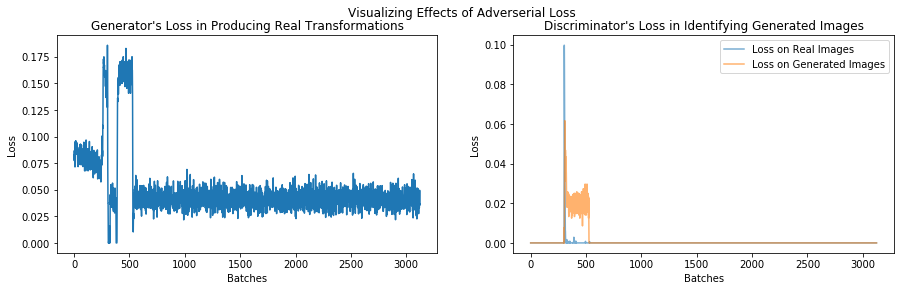

In [30]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.suptitle("Visualizing Effects of Adverserial Loss")
plt.title("Generator's Loss in Producing Real Transformations")
plt.xlabel("Batches")
plt.ylabel("Loss")
pd.Series(genloss).plot()
plt.subplot(1,2,2)
plt.title("Discriminator's Loss in Identifying Generated Images")
plt.xlabel("Batches")
plt.ylabel("Loss")
pd.Series(drealloss).plot(label="Loss on Real Images", alpha=0.6)
pd.Series(dfakeloss).plot(label="Loss on Generated Images", alpha=0.6)
plt.legend(loc="best")
plt.show()

In [43]:
def get_inference(generator,X1,X2):
    Y = np.zeros((X1.shape[0],25,25,1))
    leftend = 0
    while leftend<X1.shape[0]:
        firstdata = X1[leftend:(leftend+256)]
        seconddata = np.zeros((firstdata.shape[0],2), dtype=np.int32)
        seconddata[:,0] = np.arange(firstdata.shape[0])
        seconddata[:,1] = np.argmax(X2[leftend:(leftend+256)],axis=1)
        Y[leftend:(leftend+256)] = generator.predict_on_batch([firstdata, seconddata])
        leftend+=256
    return Y